# CUSTOMER CHURNING IN ONLINE RETAIL

In [1]:
# Enables multiple prints from one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [82]:
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Import online retail dataset
dtypes = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity' : np.int64, 'InvoiceDate': str,
        'UnitPrice': np.float32, 'CustomerID' : str, 'Country': str}
f = pd.read_csv('D:/DSTI/12_ANN/Retail/RetailData.csv', encoding = 'unicode_escape', parse_dates=[4], dtype=dtypes)

In [4]:
# First look in the dataset properties
f.shape
f.dtypes
f.head()

(541909, 8)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float32
CustomerID             object
Country                object
dtype: object

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

I had problems with opening the file with default options (utf-8 encoding error on position 28), so I added " encoding = 'unicode_escape'  ". I assume it might be in Description column.     

In [5]:
# Summary for several fetures
f['Quantity'].describe()
f['UnitPrice'].describe()
f['CustomerID'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

count    541909.000000
mean          4.616765
std          96.714073
min      -11062.059570
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

count     406829
unique      4372
top        17841
freq        7983
Name: CustomerID, dtype: object

In [6]:
#f.sort_values(['UnitPrice'], ascending=True)

We have NaN for CustomerId and negative velues for quantity and UnitPrice.

In [6]:
# df.describe() will automatically summarise numeric features
#f.describe()

In [8]:
#The first and last date in the dataset and the timespan
min_date_f = min(f['InvoiceDate'])
min_date_f
max_date_f = max(f['InvoiceDate'])
max_date_f
max_date_f - min_date_f

Timestamp('2010-12-01 08:26:00')

Timestamp('2011-12-09 12:50:00')

Timedelta('373 days 04:24:00')

In [7]:
f_country = pd.DataFrame(f.Country)
len(f_country.Country.unique())

38

We have 38 different categories for the country: 37 countries and 'unspecified'

For which country we have the most data? Filter out only data for this country.

In [9]:
f_country.groupby(['Country']).size().sort_values(ascending=False)

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


The most customers come from UK. Some have NaN for CustomerID, which I removed. 
The suggested features in the literature don't take into account the returns, they only account for the buys. From user experience point of view, I assume that if number of returns equals the number of buys, customer will sooner or later change the provider. Therefore, I construct below NoReturns andn NoSuccesfulPurchase. 
The returns can be complete (full order was returned) or partial (only a part of the order was returned). While I assume that mostly complete returns account for dissatisfaction, i didn't separate them. NoSuccesfulPurchase couns the purchase without any return, not even partial. 	

I don't have any missing values in the dataset. (below)

In [11]:
# For the working dataset I will only select UK customers with known customer id
f_uk = f[f.Country == 'United Kingdom']
f_uk = f_uk[f.CustomerID.notnull()]
#f_uk = f_uk[f.Quantity > 0]   #cannot eliminate -> return
#f_uk = f_uk[f.UnitPrice > 0]  #cannot eliminate -> balance adjustment (only for NaN customer; anyway)
#f_uk.sort_values(['StockCode'], ascending=False).head()
f_uk.shape
f_uk.isnull().values.any()

C:\Users\yannd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(361878, 8)

False

In [13]:
# Verify all unique StockCodes. Some are descriptional (post, bank charges...).
# Can it explain sth for negative invoices?
'''
stockcode = f_uk.StockCode.sort_values().unique()
#stockcode.dtype
#len(stockcode)
#s = stockcode.sort_values()
print(stockcode)

for i in stockcode:
    print(i)
'''

'\nstockcode = f_uk.StockCode.sort_values().unique()\n#stockcode.dtype\n#len(stockcode)\n#s = stockcode.sort_values()\nprint(stockcode)\n\nfor i in stockcode:\n    print(i)\n'

In [81]:
#f_uk[f_uk.StockCode == "D"]

In [14]:
# Select pertinent columns and make a new table
df_uk = f_uk.iloc[:, [0, 3, 4, 5, 6]].copy()
df_uk.head()

InvoiceNo  Quantity         InvoiceDate  UnitPrice CustomerID
0    536365         6 2010-12-01 08:26:00       2.55      17850
1    536365         6 2010-12-01 08:26:00       3.39      17850
2    536365         8 2010-12-01 08:26:00       2.75      17850
3    536365         6 2010-12-01 08:26:00       3.39      17850
4    536365         6 2010-12-01 08:26:00       3.39      17850

In [15]:
# Remove time from date time format in InvoiceDate
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate']).dt.date
df_uk.head()

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID
0    536365         6  2010-12-01       2.55      17850
1    536365         6  2010-12-01       3.39      17850
2    536365         8  2010-12-01       2.75      17850
3    536365         6  2010-12-01       3.39      17850
4    536365         6  2010-12-01       3.39      17850

In [17]:
#Determine date of the first and last invoice in selected data
# The span of data is 373 days
min_date = min(df_uk['InvoiceDate'])
min_date
max_date = max(df_uk['InvoiceDate'])
max_date
max_date - min_date

datetime.date(2010, 12, 1)

datetime.date(2011, 12, 9)

datetime.timedelta(days=373)

In [18]:
# Add column TotalPrice = UnitPrice * Quantity
df_uk['TotalPrice'] = df_uk['UnitPrice'] * df_uk['Quantity']
df_uk.head()

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID  TotalPrice
0    536365         6  2010-12-01       2.55      17850   15.299999
1    536365         6  2010-12-01       3.39      17850   20.340000
2    536365         8  2010-12-01       2.75      17850   22.000000
3    536365         6  2010-12-01       3.39      17850   20.340000
4    536365         6  2010-12-01       3.39      17850   20.340000

In [19]:
# Construct new table with information: 
##CustomerID, 
##FirstInvoice - for each customer
##LastInvoice - for each customer
##DaysCustomer = LastInvoice - FirstInvoice
##NoPurchases = number of different positive invoices 
##NoReturns = number of returned purchases (negative invoices)
##TotalSpent = sum of all invoices
##TotalItems = sum of all items bought
##Churn = if last invoice more than 6 months ago



In [20]:
##FirstInvoice
first_inv = df_uk.groupby(['CustomerID'])['InvoiceDate'].min()
first_inv = first_inv.rename('FirstInvoice', inplace=True)
first_inv.head()

first_inv['17448']

CustomerID
12346    2011-01-18
12747    2010-12-05
12748    2010-12-01
12749    2011-05-10
12820    2011-01-17
Name: FirstInvoice, dtype: object

datetime.date(2011, 7, 18)

In [21]:
##LastInvoice
last_inv = df_uk.groupby(['CustomerID'])['InvoiceDate'].max()
last_inv = last_inv.rename("LastInvoice", inplace=True)
last_inv.head()

last_inv['17448']

CustomerID
12346    2011-01-18
12747    2011-12-07
12748    2011-12-09
12749    2011-12-06
12820    2011-12-06
Name: LastInvoice, dtype: object

datetime.date(2011, 7, 18)

In [22]:
## NoPurchases = number of different invoices 
## This is not what I want. It lists different invoices, doesn't count them. 
## Might be useful for verification.

#no_purch = df_uk.groupby(['CustomerID', 'InvoiceNo']).size()
#no_purch.head(20)

In [23]:
##NoPurchases = number of unique invoices with positive quantities 
pos_inv = df_uk[df_uk.Quantity > 0]
pos_inv.sort_values('Quantity').head(10)

no_purch = pos_inv.groupby(['CustomerID'])['InvoiceNo'].nunique()
no_purch = no_purch.rename('NoPurchases', inplace=True)
no_purch.describe()
no_purch.sort_values(ascending=True).head(10)

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID  TotalPrice
136298    547960         1  2011-03-28       3.75      15644        3.75
144351    548739         1  2011-04-04       8.95      15493        8.95
144350    548739         1  2011-04-04       4.25      15493        4.25
144349    548739         1  2011-04-04       6.95      15493        6.95
144346    548739         1  2011-04-04       2.95      15493        2.95
144345    548739         1  2011-04-04       2.55      15493        2.55
144342    548739         1  2011-04-04       1.65      15493        1.65
144341    548739         1  2011-04-04       1.45      15493        1.45
144340    548739         1  2011-04-04       7.95      15493        7.95
144339    548739         1  2011-04-04       4.25      15493        4.25

count    3921.000000
mean        4.246111
std         7.205750
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: NoPurchases, dtype: float64

CustomerID
12346    1
15396    1
14241    1
15397    1
14238    1
14237    1
16491    1
17313    1
15405    1
17309    1
Name: NoPurchases, dtype: int64

In [26]:
##NoReturns = number of returned purchases is number of invoices with negative quantities
#Find all negative invoices
neg_inv = df_uk[df_uk.Quantity < 0]
neg_inv.sort_values('Quantity').head(10)
#Count them
no_ret = neg_inv.groupby(['CustomerID'])['InvoiceNo'].nunique()
no_ret = no_ret.rename('NoReturns', inplace=True)
no_ret.describe()
#no_ret

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID     TotalPrice
540422   C581484    -80995  2011-12-09       2.08      16446 -168469.593750
61624    C541433    -74215  2011-01-18       1.04      12346  -77183.593750
4287     C536757     -9360  2010-12-02       0.03      15838    -280.799988
160145   C550456     -3114  2011-04-18       2.10      15749   -6539.399902
160144   C550456     -2000  2011-04-18       1.85      15749   -3700.000000
160143   C550456     -1930  2011-04-18       2.55      15749   -4921.500000
224419   C556522     -1515  2011-06-13       0.55      16938    -833.250000
187609   C552995     -1350  2011-05-12       0.16      18133    -216.000000
160142   C550456     -1300  2011-04-18       2.55      15749   -3315.000000
390548   C570556     -1296  2011-10-11       1.06      16029   -1373.759888

count    1411.000000
mean        2.273565
std         2.878929
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        45.000000
Name: NoReturns, dtype: float64

In [27]:
# Verification
cid = '15749'
neg_inv[neg_inv.CustomerID == cid]
pos_inv[pos_inv.CustomerID == cid]
print('Purchased: ', no_purch[cid])
print('Returns: ', no_ret[cid])

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID   TotalPrice
160141   C550456      -670  2011-04-18       6.75      15749 -4522.500000
160142   C550456     -1300  2011-04-18       2.55      15749 -3315.000000
160143   C550456     -1930  2011-04-18       2.55      15749 -4921.500000
160144   C550456     -2000  2011-04-18       1.85      15749 -3700.000000
160145   C550456     -3114  2011-04-18       2.10      15749 -6539.399902

InvoiceNo  Quantity InvoiceDate  UnitPrice CustomerID   TotalPrice
52709     540815      1930  2011-01-11       2.55      15749  4921.500000
52710     540815      2000  2011-01-11       1.85      15749  3700.000000
52711     540815      3114  2011-01-11       2.10      15749  6539.399902
52771     540818      1300  2011-01-11       2.55      15749  3315.000000
52772     540818       670  2011-01-11       6.75      15749  4522.500000
160542    550461      1930  2011-04-18       2.40      15749  4632.000000
160543    550461      1300  2011-04-18       2.10      15749  2729.999756
160544    550461       670  2011-04-18       6.35      15749  4254.500000
160545    550461      2000  2011-04-18       1.69      15749  3380.000000
160546    550461      3114  2011-04-18       2.10      15749  6539.399902

Purchased:  3
Returns:  1


In [28]:
##TotalSpent = sum of all invoices
tot_spent = df_uk.groupby(['CustomerID'])['TotalPrice'].sum()
tot_spent = tot_spent.rename('TotalSpent', inplace=True)
tot_spent.sort_values().head()

CustomerID
17448   -4287.629883
15369   -1592.489990
14213   -1192.199951
17603   -1165.300049
15823    -840.760010
Name: TotalSpent, dtype: float32

In [29]:
# Very big variation in total expenditure. Check for errors
tot_spent.describe()
#tot_spent.head()

count      3950.000000
mean       1713.383789
std        6548.606445
min       -4287.629883
25%         282.255005
50%         627.059998
75%        1521.782532
max      256438.484375
Name: TotalSpent, dtype: float64

In [30]:
##TotalItems = sum of all items bought
tot_items = df_uk.groupby(['CustomerID'])['Quantity'].sum()
tot_items = tot_items.rename("TotalItems", inplace=False)
tot_items.describe()

count     3950.000000
mean      1014.818481
std       3198.469949
min       -303.000000
25%        147.000000
50%        355.000000
75%        928.750000
max      69029.000000
Name: TotalItems, dtype: float64

In [31]:
# Merge in one df
df_concat = pd.concat([first_inv, last_inv], axis=1)

# Add one day, otherwise [FirstInvoivce: 2011-01-18 LastInvoice: 2011-01-18] is customer for zero days
df_concat['DaysCustomer'] = (max_date - df_concat['FirstInvoice']).dt.days
df2 = pd.concat([df_concat, no_purch, no_ret, tot_spent, tot_items], axis=1)

df2.head()


C:\Users\yannd\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
12346   2011-01-18  2011-01-18           325          1.0        1.0   
12747   2010-12-05  2011-12-07           369         11.0        NaN   
12748   2010-12-01  2011-12-09           373        210.0       14.0   
12749   2011-05-10  2011-12-06           213          5.0        3.0   
12820   2011-01-17  2011-12-06           326          4.0        NaN   

         TotalSpent  TotalItems  
12346      0.000000           0  
12747   4196.009766        1275  
12748  29072.099609       24210  
12749   3868.199951        1422  
12820    942.340027         722

In [32]:
#Fill all NaNs with 0
values = {'NoPurchases': 0, 'NoReturns': 0}
df2 = df2.fillna(value=values)
df2.head()

df2.shape

df2.isnull().values.any()

FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
12346   2011-01-18  2011-01-18           325          1.0        1.0   
12747   2010-12-05  2011-12-07           369         11.0        0.0   
12748   2010-12-01  2011-12-09           373        210.0       14.0   
12749   2011-05-10  2011-12-06           213          5.0        3.0   
12820   2011-01-17  2011-12-06           326          4.0        0.0   

         TotalSpent  TotalItems  
12346      0.000000           0  
12747   4196.009766        1275  
12748  29072.099609       24210  
12749   3868.199951        1422  
12820    942.340027         722

(3950, 7)

False

In [33]:
# Some customers have 'TotalSpent' negative. 
# Explanation could be that they made a purchase before the data collection started and they returned the 
# goods during data collection period. Since this skews the data, I will filter all those out.
df2.sort_values(['TotalSpent']).head()

df2 = df2[df2.TotalSpent > 0]
df2.sort_values(['TotalSpent']).head()


FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
17448   2011-07-18  2011-07-18           144          0.0        1.0   
15369   2011-07-18  2011-07-18           144          0.0        1.0   
14213   2010-12-03  2010-12-03           371          0.0        1.0   
17603   2011-03-17  2011-10-20           267          1.0        4.0   
15823   2010-12-02  2011-01-06           372          1.0        1.0   

        TotalSpent  TotalItems  
17448 -4287.629883          -1  
15369 -1592.489990          -1  
14213 -1192.199951        -244  
17603 -1165.300049         -31  
15823  -840.760010        -283

FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
16446   2011-05-18  2011-12-09           205          2.0        1.0   
16738   2011-02-15  2011-02-15           297          1.0        0.0   
17956   2011-04-04  2011-04-04           249          1.0        0.0   
13307   2011-08-11  2011-08-11           120          1.0        0.0   
17763   2011-03-21  2011-03-21           263          1.0        0.0   

       TotalSpent  TotalItems  
16446        2.90           2  
16738        3.75           3  
17956       12.75           1  
13307       15.00           4  
17763       15.00          12

In [34]:
#f_uk[f_uk.CustomerID == '16446']

In [35]:
# How long the sustomer didn't place the order?
df2['DaysNotOrdered'] = (max_date - df2['LastInvoice']).dt.days
df2.head()

FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
12747   2010-12-05  2011-12-07           369         11.0        0.0   
12748   2010-12-01  2011-12-09           373        210.0       14.0   
12749   2011-05-10  2011-12-06           213          5.0        3.0   
12820   2011-01-17  2011-12-06           326          4.0        0.0   
12821   2011-05-09  2011-05-09           214          1.0        0.0   

         TotalSpent  TotalItems  DaysNotOrdered  
12747   4196.009766        1275               2  
12748  29072.099609       24210               0  
12749   3868.199951        1422               3  
12820    942.340027         722               3  
12821     92.720001          70             214

In [36]:
#Check that 'DaysCustomer' always bigger then 'DaysNotOrdered'
check = df2['DaysCustomer'] < df2['DaysNotOrdered']
check.sum()

0

In [120]:
#Delta 122 days (4 months) determines churned customers 
delta =  122

condlist = [df2['DaysNotOrdered'] > delta]
choicelist = [1]
df2['Churn'] = np.select(condlist, choicelist)
df2['Churn'] = df2['Churn'].astype('category')
df2.sort_values(['Churn', 'TotalSpent'], ascending=True).head()

FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
16446   2011-05-18  2011-12-09           205          2.0        1.0   
13307   2011-08-11  2011-08-11           120          1.0        0.0   
16093   2011-08-25  2011-08-25           106          1.0        0.0   
16953   2011-11-09  2011-11-09            30          1.0        0.0   
17986   2011-10-14  2011-10-14            56          1.0        0.0   

       TotalSpent  TotalItems  DaysNotOrdered  Stay Churn  
16446    2.900000           2               0     0     0  
13307   15.000000           4             120     0     0  
16093   17.000000          20             106     0     0  
16953   20.799999          10              30     0     0  
17986   20.799999          10              56     0     0

In [123]:
df2 = df2.drop(['Churn'], axis=1)
df2.head()

FirstInvoice LastInvoice  DaysCustomer  NoPurchases  NoReturns  \
12747   2010-12-05  2011-12-07           369         11.0        0.0   
12748   2010-12-01  2011-12-09           373        210.0       14.0   
12749   2011-05-10  2011-12-06           213          5.0        3.0   
12820   2011-01-17  2011-12-06           326          4.0        0.0   
12821   2011-05-09  2011-05-09           214          1.0        0.0   

         TotalSpent  TotalItems  DaysNotOrdered Churn  
12747   4196.009766        1275               2     0  
12748  29072.099609       24210               0     0  
12749   3868.199951        1422               3     0  
12820    942.340027         722               3     0  
12821     92.720001          70             214     1

In [125]:
#How many customers churn under defined conditions?
sum(df2['Churn'])

1060

In [126]:
df2.describe()

DaysCustomer  NoPurchases    NoReturns     TotalSpent    TotalItems  \
count   3902.000000  3902.000000  3902.000000    3902.000000   3902.000000   
mean     225.057150     4.261148     0.807278    1737.501221   1024.509482   
std      118.464525     7.220000     2.046942    6584.707031   3210.699650   
min        1.000000     1.000000     0.000000       2.900000      0.000000   
25%      114.000000     1.000000     0.000000     292.325005    153.000000   
50%      252.000000     2.000000     0.000000     637.005005    361.000000   
75%      331.000000     5.000000     1.000000    1538.872437    939.750000   
max      373.000000   210.000000    45.000000  256438.484375  69029.000000   

       DaysNotOrdered  
count     3902.000000  
mean        89.676832  
std         98.682092  
min          0.000000  
25%         16.000000  
50%         49.000000  
75%        138.000000  
max        373.000000

Here we see that mostly the distributions are skewed (comparison between 75% and max).

In [43]:
#df2 = df2.drop(['NoSuccesfulPurchase'], axis=1)
#df2.head()

In [41]:
# KICKED OUT 
'''
#RUN ONLY ONCE!
df2.insert(5, 'NoSuccesfulPurchase', df2.NoPurchases-df2.NoReturns)
df2.insert(6, 'SuccessRate', df2.NoSuccesfulPurchase/(df2.NoReturns+df2.NoSuccesfulPurchase))
df2.drop(['SuccessRate'], axis=1)
df2.insert(7, 'SpendPerPurchase', df2.TotalSpent/df2.NoSuccesfulPurchase)
df2.head() 
#df2.sort_values('SuccessRate')
'''

"\n#RUN ONLY ONCE!\ndf2.insert(5, 'NoSuccesfulPurchase', df2.NoPurchases-df2.NoReturns)\ndf2.insert(6, 'SuccessRate', df2.NoSuccesfulPurchase/(df2.NoReturns+df2.NoSuccesfulPurchase))\ndf2.drop(['SuccessRate'], axis=1)\ndf2.insert(7, 'SpendPerPurchase', df2.TotalSpent/df2.NoSuccesfulPurchase)\ndf2.head() \n#df2.sort_values('SuccessRate')\n"

In [42]:
#df2.loc['16858']
#f[f.CustomerID == '16858']

In [127]:
# Final selection of columns
#data = df2.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].copy()
data = df2.drop(['FirstInvoice', 'LastInvoice', 'DaysNotOrdered'], axis=1)
data.head()
data.dtypes

DaysCustomer  NoPurchases  NoReturns    TotalSpent  TotalItems Churn
12747           369         11.0        0.0   4196.009766        1275     0
12748           373        210.0       14.0  29072.099609       24210     0
12749           213          5.0        3.0   3868.199951        1422     0
12820           326          4.0        0.0    942.340027         722     0
12821           214          1.0        0.0     92.720001          70     1

DaysCustomer       int64
NoPurchases      float64
NoReturns        float64
TotalSpent       float32
TotalItems         int64
Churn           category
dtype: object

In [46]:
'''
#data.sort_values('SpendPerPurchase', ascending=False)

# Replace inf in SpendPerPurchase with 0
# Inf comes from 0 division where NoSuccesfulPurchase = 0

data = data.replace([np.inf, -np.inf], 0)
data.head()

#data.sort_values('SpendPerPurchase', ascending=True)
'''

"\n#data.sort_values('SpendPerPurchase', ascending=False)\n\n# Replace inf in SpendPerPurchase with 0\n# Inf comes from 0 division where NoSuccesfulPurchase = 0\n\ndata = data.replace([np.inf, -np.inf], 0)\ndata.head()\n\n#data.sort_values('SpendPerPurchase', ascending=True)\n"

# EXPLORATORY ANALYSIS

In [227]:
# Table the churners and non-churners
data.shape
data['Churn'].value_counts()

(3902, 6)

0    2842
1    1060
Name: Churn, dtype: int64

In [48]:
'''
print('DaysCustomer')
data.groupby('Churn').DaysCustomer.describe()
#a = sns.boxplot(x="Churn", y="DaysCustomer", hue="Churn", data=data, palette="Set3")

print('Number of returns')
data.groupby('Churn').NoReturns.describe()
#b = sns.boxplot(x="Churn", y="NoReturns", hue="Churn", data=data, palette="Set3")

print('NoSuccesfulPurchase')
data.groupby('Churn').NoSuccesfulPurchase.describe()
#ax = sns.boxplot(x="Churn", y="NoSuccesfulPurchase", hue="Churn", data=data, palette="Set3")

print('TotalSpent')
data.groupby('Churn').TotalSpent.describe()
#ax = sns.boxplot(x="Churn", y="TotalSpent", hue="Churn", data=data, palette="Set3")

print('SuccessRate')
data.groupby('Churn').SuccessRate.describe()

print('SpendPerPurchase')
data.groupby('Churn').SpendPerPurchase.describe()

print('TotalItems')
data.groupby('Churn').TotalItems.describe()
#ax = sns.boxplot(x="Churn", y="TotalItems", hue="Churn", data=data, palette="Set3")

print('DaysNotOrdered')
data.groupby('Churn').DaysNotOrdered.describe()
#ax = sns.boxplot(x="Churn", y="DaysNotOrdered", hue="Churn", data=data, palette="Set3")
'''

'\nprint(\'DaysCustomer\')\ndata.groupby(\'Churn\').DaysCustomer.describe()\n#a = sns.boxplot(x="Churn", y="DaysCustomer", hue="Churn", data=data, palette="Set3")\n\nprint(\'Number of returns\')\ndata.groupby(\'Churn\').NoReturns.describe()\n#b = sns.boxplot(x="Churn", y="NoReturns", hue="Churn", data=data, palette="Set3")\n\nprint(\'NoSuccesfulPurchase\')\ndata.groupby(\'Churn\').NoSuccesfulPurchase.describe()\n#ax = sns.boxplot(x="Churn", y="NoSuccesfulPurchase", hue="Churn", data=data, palette="Set3")\n\nprint(\'TotalSpent\')\ndata.groupby(\'Churn\').TotalSpent.describe()\n#ax = sns.boxplot(x="Churn", y="TotalSpent", hue="Churn", data=data, palette="Set3")\n\nprint(\'SuccessRate\')\ndata.groupby(\'Churn\').SuccessRate.describe()\n\nprint(\'SpendPerPurchase\')\ndata.groupby(\'Churn\').SpendPerPurchase.describe()\n\nprint(\'TotalItems\')\ndata.groupby(\'Churn\').TotalItems.describe()\n#ax = sns.boxplot(x="Churn", y="TotalItems", hue="Churn", data=data, palette="Set3")\n\nprint(\'DaysN

In [592]:
# Convert wide dataframe to long
#pd.melt(data,id_vars=['state'],var_name='year', value_name='unemployment')

KeyError: "The following 'id_vars' are not present in the DataFrame: ['state']"

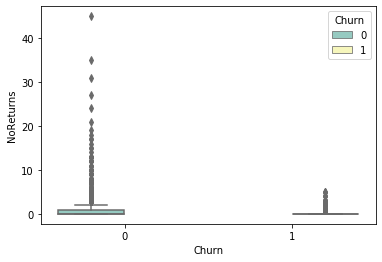

In [596]:
a = sns.boxplot(x="Churn", y="NoReturns", hue="Churn", data=data, palette="Set3")

Text(0.5, 1.0, '')

Text(0.5, 0, 'NoReturns')

Text(0, 0.5, 'Density')

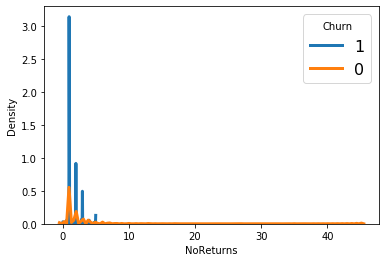

In [129]:
#ax = sns.distplot(x="Churn", y="NoSuccesfulPurchase", hue="Churn", data=data, palette="Set3")

# List of five airlines to plot
values = [1, 0]

# Iterate through the five airlines
for value in values:
    # Subset to the airline
    subset = data[data['Churn'] == value]
    
    # Draw the density plot
    sns.distplot(subset['NoReturns'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = value)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Churn')
plt.title('')
plt.xlabel('NoReturns')
plt.ylabel('Density')

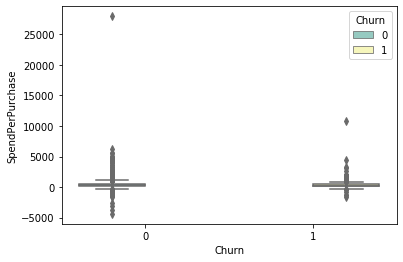

In [633]:
#iris = sns.load_dataset("iris")
ax = sns.boxplot(x="Churn", y="SpendPerPurchase", hue="Churn", data=data, palette="Set3")


# FEATURE DISTRIBUTION 

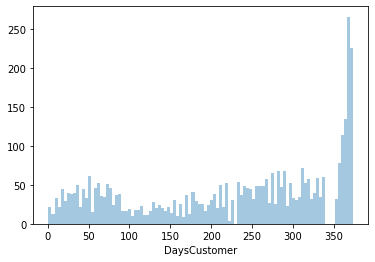

In [231]:
sns.distplot(data['DaysCustomer'], kde=False, bins=100)
#sns.distplot(data['NoReturns'], kde=False)
#sns.distplot(data['NoReturns'], kde=False)
#sns.distplot(data['NoSuccesfulPurchase'])
#sns.distplot(data['SuccessRate'])
#sns.distplot(data['SpendPerPurchase'], kde=False)
#sns.distplot(data['TotalSpent'], kde=False, bins=100)
#sns.distplot(data['TotalItems'], kde=False, bins=100)

None of the variables are normally distributed. Therefore, we need to use non-parametric methods, which don't use any prior about underlying distribution.
Common examples include kNN (k is a parameter, but technically not an effective one - I don’t have the mental acuity at the moment to explain without getting mathematical), decision trees (with boosting, bagging, and random forests), kernel methods of all sorts, support vector classifiers- well, that’s a toss-up, any hierarchical Bayesian classifier with a Dirichlet (hyper)prior… this list goes on.

# SPLIT DATASET ON DATA AND TARGET

In [132]:
df_target = data.Churn

ncols = data.shape[1]
#df_data = data.iloc[:, 0:ncols-2]
#DaysNotOrdered removed since used to determine churning customers

# With modified dataset DaysNotOrdered was removed before
df_data = data.iloc[:, 0:ncols-1]

df_target.head()
df_data.head()

12747    0
12748    0
12749    0
12820    0
12821    1
Name: Churn, dtype: category
Categories (2, int64): [0, 1]

DaysCustomer  NoPurchases  NoReturns    TotalSpent  TotalItems
12747           369         11.0        0.0   4196.009766        1275
12748           373        210.0       14.0  29072.099609       24210
12749           213          5.0        3.0   3868.199951        1422
12820           326          4.0        0.0    942.340027         722
12821           214          1.0        0.0     92.720001          70

# FEATURE SELECTION

<Figure size 360x360 with 0 Axes>

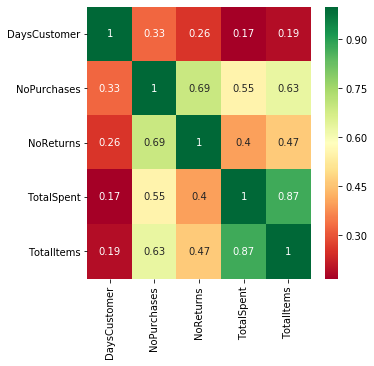

In [133]:
#get correlations of each features in dataset
corrmat = df_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [54]:
'''
df_data = df_data.drop(['NoSuccesfulPurchase'], axis=1)
#get correlations of each features in dataset
corrmat = df_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
'''

'\ndf_data = df_data.drop([\'NoSuccesfulPurchase\'], axis=1)\n#get correlations of each features in dataset\ncorrmat = df_data.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(5,5))\n#plot heat map\ng=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")\n'

# TEST-TRAIN-VALIDATION SPLIT; FEATURE SCALING

Since most of the attributes are skewed or with outliers, I will scale my data with robust scaler   

In [134]:
#First we need to split on train-validation-test sets and then scale. 
#Otherwise, we will include future information in the model.

# Train 70%, test 15%, validation 15%

X_train, X_rest, y_train,y_rest = train_test_split(df_data, df_target, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [135]:
# Robust scaling with 20th and 80th quantile
rs = RobustScaler(quantile_range=(20.0, 80.0))
scaler = rs.fit(X_train)
X_train_sc = scaler.transform(X_train)  

X_test_sc = scaler.transform(X_test)   
X_valid_sc = scaler.transform(X_valid)   


In [136]:
x = pd.DataFrame(X_train_sc)
x.describe()
X_train_sc.mean(axis=0)
X_train_sc.std(axis=0)

0            1            2            3            4
count  2731.000000  2731.000000  2731.000000  2731.000000  2731.000000
mean     -0.100645     0.425632     0.741120     0.634119     0.642722
std       0.426520     1.379266     1.712267     3.467629     3.268963
min      -0.900000    -0.200000     0.000000    -0.385981    -0.342942
25%      -0.507143    -0.200000     0.000000    -0.207239    -0.191849
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.282143     0.600000     1.000000     0.536617     0.551193
max       0.428571    41.600000    27.000000   116.394628    68.274354

array([-0.10064471,  0.42563164,  0.74112047,  0.63411877,  0.64272221])

array([0.42644157, 1.37901384, 1.71195338, 3.46699433, 3.26836424])

In [137]:
# Robust scaling with 10th and 90th quantile
rs = RobustScaler(quantile_range=(10.0, 90.0))
scaler = rs.fit(X_train)
X_train_sc = scaler.transform(X_train)  

X_test_sc = scaler.transform(X_test)   
X_valid_sc = scaler.transform(X_valid)   

x = pd.DataFrame(X_train_sc)
x.describe()
X_train_sc.mean(axis=0)
X_train_sc.std(axis=0)

0            1            2            3            4
count  2731.000000  2731.000000  2731.000000  2731.000000  2731.000000
mean     -0.087246     0.266020     0.370560     0.330935     0.341743
std       0.369738     0.862041     0.856133     1.809690     1.738148
min      -0.780186    -0.125000     0.000000    -0.201436    -0.182347
25%      -0.439628    -0.125000     0.000000    -0.108154    -0.102008
50%       0.000000     0.000000     0.000000     0.000000     0.000000
75%       0.244582     0.375000     0.500000     0.280050     0.293076
max       0.371517    26.000000    13.500000    60.744164    36.302326

array([-0.08724619,  0.26601977,  0.37056023,  0.33093464,  0.34174342])

array([0.36967071, 0.86188365, 0.85597669, 1.80935902, 1.73783004])

# SVM

In [138]:
svc = SVC()
svc.fit(X_train_sc, y_train)
y_pred = svc.predict(X_valid_sc)
svc.score(X_valid_sc, y_valid)

C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

0.8703071672354948

In [139]:
y_valid.value_counts()
cm = confusion_matrix(y_valid, y_pred)
pd.DataFrame(cm)
#target_names = ['class 0', 'class 1']
print(classification_report(y_valid, y_pred))

0    427
1    159
Name: Churn, dtype: int64

0    1
0  400   27
1   49  110

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       427
           1       0.80      0.69      0.74       159

    accuracy                           0.87       586
   macro avg       0.85      0.81      0.83       586
weighted avg       0.87      0.87      0.87       586



In [65]:
# For the company's business, the most important is to identify as meny churners as possible and less important 

# RANDOM FOREST

In [160]:
# Instantiate model with 1000 decision trees
clf = RandomForestClassifier()
# Train the model on training data
clf.fit(X_train_sc, y_train)

C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [161]:
# Use the forest's predict method on the test data
y_pred_rf = clf.predict(X_valid_sc)

In [162]:
cm_rf = confusion_matrix(y_valid, y_pred_rf)
pd.DataFrame(cm_rf)
print(classification_report(y_valid, y_pred_rf))

0    1
0  404   23
1   46  113

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       427
           1       0.83      0.71      0.77       159

    accuracy                           0.88       586
   macro avg       0.86      0.83      0.84       586
weighted avg       0.88      0.88      0.88       586



In [163]:
# Saving feature names for later use
feature_list = list(df_data.columns)

# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: DaysCustomer         Importance: 0.4
Variable: NoPurchases          Importance: 0.21
Variable: TotalItems           Importance: 0.19
Variable: TotalSpent           Importance: 0.16
Variable: NoReturns            Importance: 0.03


[None, None, None, None, None]

# GradientBoosting

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

In [205]:
#building the model & printing the score
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_sc, y_train)
    
# Use the forest's predict method on the test data
y_pred_gb = gb_clf.predict(X_valid_sc)

print(confusion_matrix(y_valid, y_pred_gb))
print(classification_report(y_valid, y_pred_gb))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

[[405  22]
 [ 45 114]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       427
           1       0.84      0.72      0.77       159

    accuracy                           0.89       586
   macro avg       0.87      0.83      0.85       586
weighted avg       0.88      0.89      0.88       586



In [206]:
# Get numerical feature importances
importances = list(gb_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: DaysCustomer         Importance: 0.53
Variable: NoPurchases          Importance: 0.35
Variable: TotalSpent           Importance: 0.06
Variable: TotalItems           Importance: 0.05
Variable: NoReturns            Importance: 0.01


[None, None, None, None, None]

# kNN

In [147]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train_sc, y_train)

#Predict the response for test dataset
y_pred_knn = knn.predict(X_valid_sc)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [148]:
cm_knn = confusion_matrix(y_valid, y_pred_knn)
pd.DataFrame(cm_knn)
print(classification_report(y_valid, y_pred_knn))

0    1
0  402   25
1   45  114

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       427
           1       0.82      0.72      0.77       159

    accuracy                           0.88       586
   macro avg       0.86      0.83      0.84       586
weighted avg       0.88      0.88      0.88       586



# 1. IMPROVMENT : IMBALANCE CORRECTION

# 2. IMPROVMENT : HYPERPARAMETER TUNNING (RANDOM GRID SEARCH)

To improve the performance of the models, we need to find the optimal parameters. There exist several different approaches, like grid search (exostive search over given prameters), random search (search over random combinations of specified parameters) and bayesian methods, where the next search will be based on the knowledge of the past best combinations. Here, I decised to use random search on all four of my models.  

In [215]:
from sklearn.metrics import recall_score, f1_score, make_scorer
recall_scorer = make_scorer(recall_score)

def hypertuning_rscv(est, p_grid, n_iter, X, y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_grid, n_jobs=-1, n_iter=n_iter, 
                                   cv=10, scoring=recall_scorer, random_state=42)
    
    rdmsearch.fit(X, y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score



f1_scorer = make_scorer(f1_score)
def hypertuning_rscv_f1(est, p_grid, n_iter, X, y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_grid, n_jobs=-1, n_iter=n_iter, 
                                   cv=10, scoring=f1_scorer, random_state=42)
    
    rdmsearch.fit(X, y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

## 2.1 SVM

### 2.1.1 SVM Score=Recall

In [187]:
from sklearn.model_selection import GridSearchCV
# Initialize RandomSearchCV
svc_est = SVC()

# Create the hyperparameter grid
svc_param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [1, 3, 5],
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']}]


grid_search_scv = GridSearchCV(svc_est, svc_param_grid, scoring='recall', cv=10, n_jobs=-1)
grid_search_scv.fit(X_train_sc, y_train)

# Run the randomized search
#svc_rscv_params, svc_rscv_score = hypertuning_rscv(svc_est, svc_param_grid, 100, X_train_sc, y_train)

C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear'...
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    'auto', 'scale'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [1, 3, 5],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    'auto', 'scale'],
                          'kernel': ['poly']},
                         {'C': [1, 10, 1

In [188]:
grid_search_scv.best_params_
grid_search_scv.best_score_

{'C': 100, 'degree': 5, 'gamma': 0.8, 'kernel': 'poly'}

0.931083273911619

In [189]:
# Based on best parameters, I construct my classifier
best_clf_svc = SVC(C=100, degree=5, gamma=0.8, kernel='poly')

In [190]:
best_clf_svc.fit(X_train_sc, y_train)
y_valid_pred_svc = best_clf_svc.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_svc))
print(classification_report(y_valid, y_valid_pred_svc))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=5, gamma=0.8, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[316 111]
 [ 12 147]]
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       427
           1       0.57      0.92      0.71       159

    accuracy                           0.79       586
   macro avg       0.77      0.83      0.77       586
weighted avg       0.86      0.79      0.80       586



### 2.1.2 SVM Score=f1

In [207]:
from sklearn.model_selection import GridSearchCV
# Initialize RandomSearchCV
svc_est = SVC()

# Create the hyperparameter grid
svc_param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [1, 3, 5],
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']},
                  {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 'auto', 'scale']}]


grid_search_scv_f1 = GridSearchCV(svc_est, svc_param_grid, scoring='f1', cv=10, n_jobs=-1)
grid_search_scv_f1.fit(X_train_sc, y_train)

grid_search_scv_f1.best_params_
grid_search_scv_f1.best_score_

C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear'...
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    'auto', 'scale'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [1, 3, 5],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                    'auto', 'scale'],
                          'kernel': ['poly']},
                         {'C': [1, 10, 1

{'C': 100, 'gamma': 0.2, 'kernel': 'rbf'}

0.7981280330297862

In [213]:
# Based on best parameters, I construct my classifier
best_clf_svc_f1 = SVC(C=100, gamma=0.2, kernel='rbf')

best_clf_svc_f1.fit(X_train_sc, y_train)
y_valid_pred_svc_f1 = best_clf_svc_f1.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_svc_f1))
print(classification_report(y_valid, y_valid_pred_svc_f1))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[398  29]
 [ 38 121]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       427
           1       0.81      0.76      0.78       159

    accuracy                           0.89       586
   macro avg       0.86      0.85      0.85       586
weighted avg       0.88      0.89      0.88       586



In [228]:
# Test set
best_clf_svc_f1 = SVC(C=100, gamma=0.2, kernel='rbf')

best_clf_svc_f1.fit(X_train_sc, y_train)
y_test_pred_svc_f1 = best_clf_svc_f1.predict(X_test_sc)
#y_valid_pred_rf
print(confusion_matrix(y_test, y_test_pred_svc_f1))
print(classification_report(y_test, y_test_pred_svc_f1))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

[[418  20]
 [ 34 113]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       438
           1       0.85      0.77      0.81       147

    accuracy                           0.91       585
   macro avg       0.89      0.86      0.87       585
weighted avg       0.91      0.91      0.91       585



## 2.2 RANDOM FOREST

### 2.2.1 RANDOM FOREST Score=Recall

In [218]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Initialize RandomSearchCV
est = RandomForestClassifier(n_jobs=-1)

# Create the hyperparameter grid
param_grid = {"max_depth": [2, 3, 5, None],
              "n_estimators": [100, 200, 500, 1000],
              "max_features": randint(1, 6),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": randint(1, 4)}


# Run the randomized search
rf_rscv_params, rf_rscv_score = hypertuning_rscv(est, param_grid, 40, X_train_sc, y_train)


In [219]:
rf_rscv_params, rf_rscv_score
# Is the score really recall? It's a bit high

({'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 4,
  'min_samples_leaf': 3,
  'n_estimators': 1000},
 0.7652629009359724)

In [220]:
# Based on best parameters, I construct my classifier
best_clf_rf = RandomForestClassifier(n_jobs=-1, bootstrap=False, criterion='entropy', max_depth=None, max_features=4,
                                    min_samples_leaf=3, n_estimators=1000)

In [221]:
best_clf_rf.fit(X_train_sc, y_train)
y_valid_pred_rf = best_clf_rf.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_rf))
print(classification_report(y_valid, y_valid_pred_rf))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

[[391  36]
 [ 40 119]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       427
           1       0.77      0.75      0.76       159

    accuracy                           0.87       586
   macro avg       0.84      0.83      0.83       586
weighted avg       0.87      0.87      0.87       586



In [ ]:
#Results with 40 iterations
'''
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

[[393  34]
 [ 38 121]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       427
           1       0.78      0.76      0.77       159

    accuracy                           0.88       586
   macro avg       0.85      0.84      0.84       586
weighted avg       0.88      0.88      0.88       586


'''

# Result with 100 iterations

'''
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=2, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

[[377  50]
 [ 30 129]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       427
           1       0.72      0.81      0.76       159

    accuracy                           0.86       586
   macro avg       0.82      0.85      0.83       586
weighted avg       0.87      0.86      0.87       586


'''

In [222]:
# Saving feature names for later use
feature_list = list(df_data.columns)

# Get numerical feature importances
importances = list(best_clf_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: NoPurchases          Importance: 0.41
Variable: DaysCustomer         Importance: 0.32
Variable: TotalSpent           Importance: 0.13
Variable: TotalItems           Importance: 0.12
Variable: NoReturns            Importance: 0.02


[None, None, None, None, None]

### 2.2.2 RANDOM FOREST Score=f1

In [216]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Initialize RandomSearchCV
est = RandomForestClassifier(n_jobs=-1)

# Create the hyperparameter grid
param_grid = {"max_depth": [2, 3, 5, None],
              "n_estimators": [100, 200, 500, 1000],
              "max_features": randint(1, 6),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "min_samples_leaf": randint(1, 4)}


# Run the randomized search
rf_rscv_params_f1, rf_rscv_score_f1 = hypertuning_rscv_f1(est, param_grid, 40, X_train_sc, y_train)
rf_rscv_params_f1, rf_rscv_score_f1


({'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 3,
  'max_features': 3,
  'min_samples_leaf': 3,
  'n_estimators': 1000},
 0.7947589515477123)

In [217]:
# Based on best parameters, I construct my classifier
best_clf_rf_f1 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=3, max_features=3,
                                        min_samples_leaf=3, n_estimators=1000)

best_clf_rf_f1.fit(X_train_sc, y_train)
y_valid_pred_rf_f1 = best_clf_rf_f1.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_rf_f1))
print(classification_report(y_valid, y_valid_pred_rf_f1))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=3, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[[399  28]
 [ 42 117]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       427
           1       0.81      0.74      0.77       159

    accuracy                           0.88       586
   macro avg       0.86      0.84      0.84       586
weighted avg       0.88      0.88      0.88       586



## 2.3 GRADIENT BOOST

### 2.3.1 GRADIENT BOOST Score=Recall

In [200]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingClassifier

# Initialize RandomSearchCV
gb_est = GradientBoostingClassifier()

# Create the hyperparameter grid
gb_param_grid = {"loss": ['deviance', 'exponential'],
              "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
              "n_estimators": [100, 200, 500, 1000],
              "subsample": [0.1, 0.5, 0.75, 1.0],
              "criterion": ["friedman_mse", "mse", "mae"],
              "min_samples_split": randint(2, 5),
              "min_samples_leaf": randint(1, 4),
              "max_depth": [2, 3, 5, None],
              "max_features": randint(1, 6),
              "warm_start": [True, False]
            }


# Run the randomized search
gb_rscv_params, gb_rscv_score = hypertuning_rscv(gb_est, gb_param_grid, 40, X_train_sc, y_train)


C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [201]:
gb_rscv_params, gb_rscv_score

({'criterion': 'mae',
  'learning_rate': 0.75,
  'loss': 'exponential',
  'max_depth': 5,
  'max_features': 3,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 500,
  'subsample': 0.1,
  'warm_start': True},
 0.7878773278858074)

In [202]:
# Based on best parameters, I construct my classifier
best_clf_gb = GradientBoostingClassifier(criterion='mae', learning_rate=0.75, loss='exponential', max_depth=5,
                                         max_features=3, min_samples_leaf=3, min_samples_split=2,
                                         n_estimators=500, subsample=0.1, warm_start=True)

In [203]:
best_clf_gb.fit(X_train_sc, y_train)
y_valid_pred_gb = best_clf_gb.predict(X_valid_sc)

print(confusion_matrix(y_valid, y_valid_pred_gb))
print(classification_report(y_valid, y_valid_pred_gb))

GradientBoostingClassifier(criterion='mae', init=None, learning_rate=0.75,
                           loss='exponential', max_depth=5, max_features=3,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=3,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=500, n_iter_no_change=None,
                           presort='auto', random_state=None, subsample=0.1,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=True)

[[393  34]
 [ 41 118]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       427
           1       0.78      0.74      0.76       159

    accuracy                           0.87       586
   macro avg       0.84      0.83      0.84       586
weighted avg       0.87      0.87      0.87       586



### 2.3.2 GRADIENT BOOST Score=f1

In [223]:
# Initialize RandomSearchCV
gb_est = GradientBoostingClassifier()

# Create the hyperparameter grid
gb_param_grid = {"loss": ['deviance', 'exponential'],
              "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
              "n_estimators": [100, 200, 500, 1000],
              "subsample": [0.1, 0.5, 0.75, 1.0],
              "criterion": ["friedman_mse", "mse", "mae"],
              "min_samples_split": randint(2, 5),
              "min_samples_leaf": randint(1, 4),
              "max_depth": [2, 3, 5, None],
              "max_features": randint(1, 6),
              "warm_start": [True, False]
            }


# Run the randomized search
gb_rscv_params_f1, gb_rscv_score_f1 = hypertuning_rscv_f1(gb_est, gb_param_grid, 40, X_train_sc, y_train)
gb_rscv_params_f1, gb_rscv_score_f1

C:\Users\yannd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'friedman_mse',
  'learning_rate': 0.075,
  'loss': 'deviance',
  'max_depth': 2,
  'max_features': 2,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100,
  'subsample': 0.1,
  'warm_start': True},
 0.8035526642578268)

In [224]:
# Based on best parameters, I construct my classifier
best_clf_gb_f1 = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.075,
                                            loss='deviance', max_depth=2, max_features=2,
                                            min_samples_leaf=1, min_samples_split=2,
                                            n_estimators=100, subsample=0.1, warm_start=True)

best_clf_gb_f1.fit(X_train_sc, y_train)
y_valid_pred_gb_f1 = best_clf_gb_f1.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_gb_f1))
print(classification_report(y_valid, y_valid_pred_gb_f1))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.1, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

[[402  25]
 [ 39 120]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       427
           1       0.83      0.75      0.79       159

    accuracy                           0.89       586
   macro avg       0.87      0.85      0.86       586
weighted avg       0.89      0.89      0.89       586



In [230]:
# Based on best parameters, I construct my classifier
best_clf_gb_f1 = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.075,
                                            loss='deviance', max_depth=2, max_features=2,
                                            min_samples_leaf=1, min_samples_split=2,
                                            n_estimators=100, subsample=0.1, warm_start=True)

best_clf_gb_f1.fit(X_train_sc, y_train)
y_test_pred_gb_f1 = best_clf_gb_f1.predict(X_test_sc)
#y_valid_pred_rf
print(confusion_matrix(y_test, y_test_pred_gb_f1))
print(classification_report(y_test, y_test_pred_gb_f1))



GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.075, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=0.1, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)

[[424  14]
 [ 35 112]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       438
           1       0.89      0.76      0.82       147

    accuracy                           0.92       585
   macro avg       0.91      0.86      0.88       585
weighted avg       0.91      0.92      0.91       585



## 2.4 kNN

### 2.4.1 kNN Score=Recall

In [192]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Create KNN Classifier
knn_est = KNeighborsClassifier()

# Create the hyperparameter grid
knn_param_grid = [{'n_neighbors': [3, 5, 10, 15, 20, 25], 'weights': ['uniform'], 
                   'leaf_size': [5, 10, 20, 30, 50], 'p': [1, 2, 3, 5]},
                  {'n_neighbors': [3, 5, 10, 15, 20, 25], 'weights': ['distance'], 
                   'leaf_size': [5, 10, 20, 30, 50], 'p': [1, 2, 3, 5]}
                 ]


grid_search_knn = GridSearchCV(knn_est, knn_param_grid, scoring='recall', cv=10, n_jobs=-1)
grid_search_knn.fit(X_train_sc, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'leaf_size': [5, 10, 20, 30, 50],
                          'n_neighbors': [3, 5, 10, 15, 20, 25],
                          'p': [1, 2, 3, 5], 'weights': ['uniform']},
                         {'leaf_size': [5, 10, 20, 30, 50],
                          'n_neighbors': [3, 5, 10, 15, 20, 25],
                          'p': [1, 2, 3, 5], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [193]:
grid_search_knn.best_params_
grid_search_knn.best_score_

{'leaf_size': 5, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

0.7095885447782767

In [194]:
# Based on best parameters, I construct my classifier
best_clf_knn = KNeighborsClassifier(leaf_size=5, n_neighbors=3, p=1, weights='distance')

In [196]:
best_clf_knn.fit(X_train_sc, y_train)
y_valid_pred_knn = best_clf_knn.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_knn))
print(classification_report(y_valid, y_valid_pred_knn))

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')

[[398  29]
 [ 42 117]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       427
           1       0.80      0.74      0.77       159

    accuracy                           0.88       586
   macro avg       0.85      0.83      0.84       586
weighted avg       0.88      0.88      0.88       586



### 2.4.2 kNN Score=f1

In [225]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#Create KNN Classifier
knn_est = KNeighborsClassifier()

# Create the hyperparameter grid
knn_param_grid = [{'n_neighbors': [3, 5, 10, 15, 20, 25], 'weights': ['uniform'], 
                   'leaf_size': [5, 10, 20, 30, 50], 'p': [1, 2, 3, 5]},
                  {'n_neighbors': [3, 5, 10, 15, 20, 25], 'weights': ['distance'], 
                   'leaf_size': [5, 10, 20, 30, 50], 'p': [1, 2, 3, 5]}
                 ]


grid_search_knn_f1 = GridSearchCV(knn_est, knn_param_grid, scoring='f1', cv=10, n_jobs=-1)
grid_search_knn_f1.fit(X_train_sc, y_train)

grid_search_knn_f1.best_params_
grid_search_knn_f1.best_score_

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'leaf_size': [5, 10, 20, 30, 50],
                          'n_neighbors': [3, 5, 10, 15, 20, 25],
                          'p': [1, 2, 3, 5], 'weights': ['uniform']},
                         {'leaf_size': [5, 10, 20, 30, 50],
                          'n_neighbors': [3, 5, 10, 15, 20, 25],
                          'p': [1, 2, 3, 5], 'weights': ['distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

{'leaf_size': 5, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}

0.7775698944298575

In [226]:
# Based on best parameters, I construct my classifier
best_clf_knn_f1 = KNeighborsClassifier(leaf_size=5, n_neighbors=15, p=1, weights='distance')

best_clf_knn_f1.fit(X_train_sc, y_train)
y_valid_pred_knn_f1 = best_clf_knn_f1.predict(X_valid_sc)
#y_valid_pred_rf
print(confusion_matrix(y_valid, y_valid_pred_knn_f1))
print(classification_report(y_valid, y_valid_pred_knn_f1))

KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=1,
                     weights='distance')

[[411  16]
 [ 51 108]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       427
           1       0.87      0.68      0.76       159

    accuracy                           0.89       586
   macro avg       0.88      0.82      0.84       586
weighted avg       0.88      0.89      0.88       586

